# 📌 Status: Finalized

This notebook is finalized and runs end-to-end without manual intervention.

Purpose:
- Notebook 02: Synthetic data generation & pricing environment
- Notebook 03: Demand forecasting & forecast validation
- Notebook 04: Price optimization & revenue impact analysis

No further changes should be made to the logic below.


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [58]:
df = pd.read_csv("../data/processed/cruise_pricing_with_bookings.csv")

df.head()

,days_to_departure,date,cabin_type,total_inventory,base_price,demand_index,elasticity,daily_shock,inventory_pressure,price_floor,price_cap,price,demand_shock,bookings,remaining_inventory,daily_revenue,cumulative_revenue,pct_sold
0,90,2025-10-21,Balcony,100,500,0.051196,0.9,0.056335,0.0,450,1000,525.0,2.004445,0,100,0.0,0.0,0.0
1,90,2025-10-21,Outside,200,350,0.054753,1.2,-0.053060,0.0,320,750,351.0,1.918507,8,200,2808.0,2808.0,0.0
2,90,2025-10-21,Interior,300,250,0.044382,1.4,-0.048535,0.0,250,600,263.0,1.055716,2,300,526.0,526.0,0.0
3,89,2025-10-22,Interior,300,250,0.043721,1.4,-0.024348,0.0,250,600,265.0,1.111212,10,298,2650.0,3176.0,0.7
4,89,2025-10-22,Outside,200,350,0.048496,1.2,-0.052824,0.0,320,750,351.0,0.925795,1,192,351.0,3159.0,4.0


In [59]:
def booking_curve(t, L=1.0, k=0.10, x0=40):
    return L / (1 + np.exp(-k * (t - x0)))


In [60]:
forecast_params = {
    "Interior": {"k": 0.12, "x0": 35},
    "Outside":  {"k": 0.09, "x0": 24},
    "Balcony":  {"k": 0.05, "x0": 15},
}

In [61]:
df = df.sort_values(
    ["cabin_type", "days_to_departure"],
    ascending=[True, False]
).reset_index(drop=True)


In [62]:
max_days = df["days_to_departure"].max()
df["time_elapsed"] = max_days - df["days_to_departure"]

In [63]:
df["curve_shape"] = df.apply(
    lambda row: booking_curve(
        row["time_elapsed"],
        L=1.0,
        k=forecast_params[row["cabin_type"]]["k"],
        x0=forecast_params[row["cabin_type"]]["x0"]
    ),
    axis=1
)

In [64]:
df = df.sort_values(
    ["cabin_type", "days_to_departure"],
    ascending=[True, False]
).reset_index(drop=True)

In [65]:
df["expected_daily_pct_raw"] = (
    df.groupby("cabin_type")["curve_shape"]
      .diff()
      .fillna(0)
      .clip(lower=0)
)

In [66]:
df["expected_pct_sold_raw"] = (
    df.groupby("cabin_type")["expected_daily_pct_raw"]
      .cumsum()
)

In [67]:
final_vals = df.groupby("cabin_type")["expected_pct_sold_raw"].transform("max")

df["expected_pct_sold"] = (
    df["expected_pct_sold_raw"] / final_vals
).clip(0, 1) * 100

df["expected_pct_sold"] = df["expected_pct_sold"].round(2)

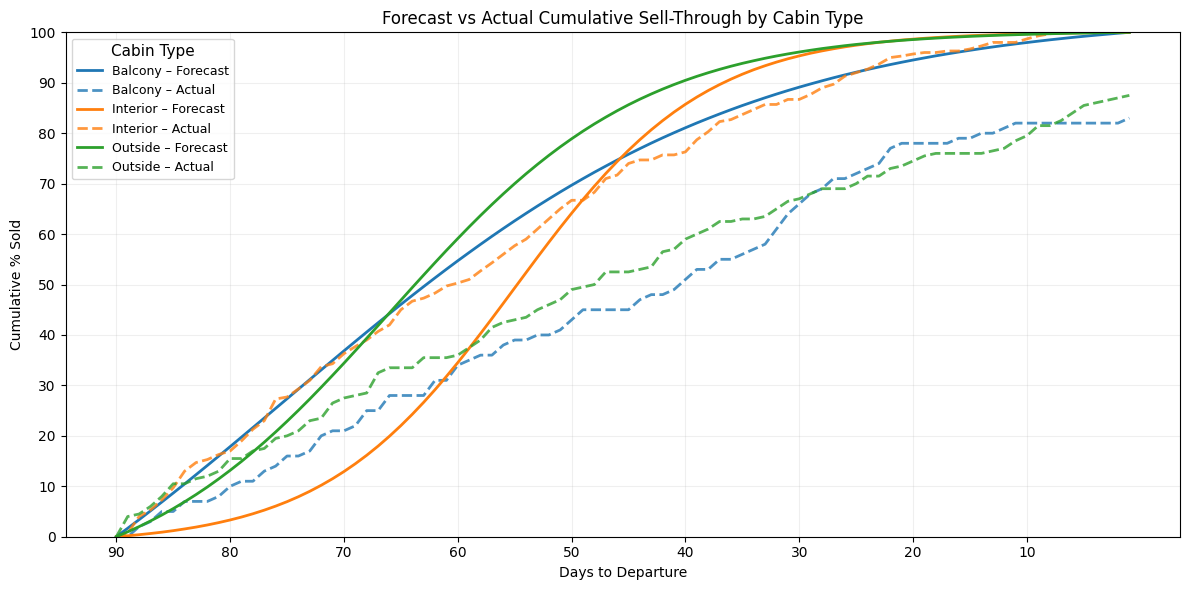

In [68]:
# Optional safety: ensure actual % is on 0–100 scale
if df["pct_sold"].max() <= 1.5:
    df["pct_sold"] = plot_df["pct_sold"] * 100

# Fixed cabin colors
cabin_colors = {
    "Interior": "#ff7f0e",  # orange
    "Outside": "#2ca02c",   # green
    "Balcony": "#1f77b4"    # blue
}

plot_df = df.sort_values(["days_to_departure", "cabin_type"], ascending=[False, True])

plt.figure(figsize=(12, 6))

for cabin in plot_df["cabin_type"].unique():
    sub = (
        plot_df[plot_df["cabin_type"] == cabin]
        .sort_values("days_to_departure", ascending=False)
    )

    color = cabin_colors.get(cabin, "black")

    # Forecast (solid)
    plt.plot(
        sub["days_to_departure"],
        sub["expected_pct_sold"],
        linewidth=2,
        color=color,
        label=f"{cabin} – Forecast"
    )

    # Actual (dashed, same color)
    plt.plot(
        sub["days_to_departure"],
        sub["pct_sold"],
        linestyle="--",
        linewidth=2,
        color=color,
        alpha=0.8,
        label=f"{cabin} – Actual"
    )

# X ticks every 10 days
xticks = list(range(
    int(plot_df["days_to_departure"].max()),
    int(plot_df["days_to_departure"].min()) - 1,
    -10
))
plt.xticks(xticks)
plt.gca().invert_xaxis()

# Y axis formatting
plt.yticks(np.arange(0, 101, 10))
plt.ylim(0, 100)

plt.xlabel("Days to Departure")
plt.ylabel("Cumulative % Sold")
plt.title("Forecast vs Actual Cumulative Sell-Through by Cabin Type")
plt.legend(
    title="Cabin Type",
    loc="upper left",
    fontsize=9,
    title_fontsize=11,
    frameon=True
)

plt.grid(alpha=0.2)

plt.tight_layout()
plt.savefig("../figures/03_forecast_vs_actual_sell_through_by_cabin.png", dpi=300)
plt.show()

In [69]:
cabin_capacity = {
    "Interior": 300,
    "Outside":  200,
    "Balcony":  100
}

In [70]:
df["expected_daily_pct"] = (
    df.groupby("cabin_type")["expected_pct_sold"]
      .diff()
      .fillna(0)
      .clip(lower=0)
)

In [71]:
df["expected_daily_units"] = (
    df["expected_daily_pct"] / 100
) * df["total_inventory"]

In [72]:
df["expected_daily_revenue"] = (
    df["expected_daily_units"] * df["price"]
).round(2)

In [73]:
df["expected_cumulative_revenue"] = (
    df.groupby("cabin_type")["expected_daily_revenue"]
      .cumsum()
).round(2)

In [74]:
df["actual_cumulative_revenue"] = (
    df.groupby("cabin_type")["daily_revenue"]
      .cumsum()
).round(2)

In [75]:
# expected cumulative units sold
df["forecast_cum_units"] = (
    df["expected_pct_sold"] / 100 * df["total_inventory"]
)

In [76]:
df = df.sort_values(
    ["cabin_type", "days_to_departure"],
    ascending=[True, False]
).reset_index(drop=True)

In [77]:
df["expected_daily_bookings"] = (
    df.groupby("cabin_type")["forecast_cum_units"]
      .diff()
      .fillna(df["forecast_cum_units"])
)

In [78]:
df["expected_daily_bookings"] = (
    df["expected_daily_bookings"]
      .clip(lower=0)
      .round()
      .astype(int)
)

In [79]:
df = df.sort_values("date").reset_index(drop=True)

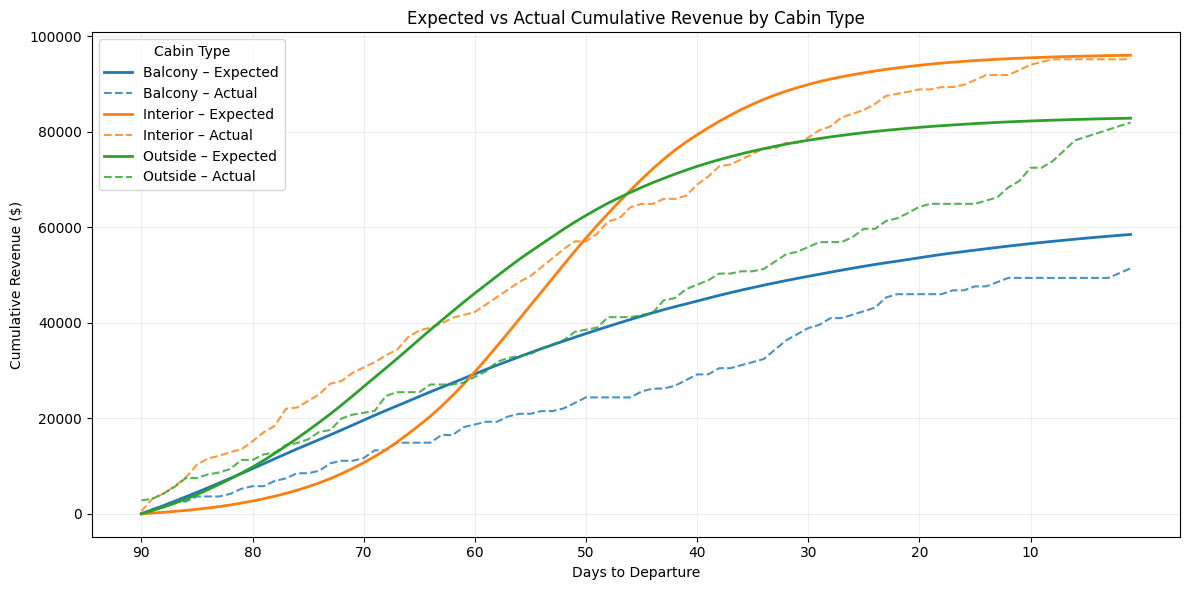

In [80]:
# Consistent cabin colors
cabin_colors = {
    "Interior": "#ff7f0e",  # orange
    "Outside": "#2ca02c",   # green
    "Balcony": "#1f77b4"    # blue
}

plot_df = df.sort_values(["days_to_departure", "cabin_type"], ascending=[False, True])

plt.figure(figsize=(12, 6))

for cabin in plot_df["cabin_type"].unique():
    sub = (
        plot_df[plot_df["cabin_type"] == cabin]
        .sort_values("days_to_departure", ascending=False)
    )

    color = cabin_colors.get(cabin, "black")

    # Expected cumulative revenue (solid)
    plt.plot(
        sub["days_to_departure"],
        sub["expected_cumulative_revenue"],
        linewidth=2,
        color=color,
        label=f"{cabin} – Expected"
    )

    # Actual cumulative revenue (dashed)
    plt.plot(
        sub["days_to_departure"],
        sub["cumulative_revenue"],
        linestyle="--",
        linewidth=1.5,
        color=color,
        alpha=0.8,
        label=f"{cabin} – Actual"
    )

# X axis
xticks = list(range(
    int(plot_df["days_to_departure"].max()),
    int(plot_df["days_to_departure"].min()) - 1,
    -10
))
plt.xticks(xticks)
plt.gca().invert_xaxis()

# Labels & title
plt.xlabel("Days to Departure")
plt.ylabel("Cumulative Revenue ($)")
plt.title("Expected vs Actual Cumulative Revenue by Cabin Type")

plt.legend(title="Cabin Type", loc="upper left")
plt.grid(alpha=0.2)

plt.tight_layout()
plt.savefig(
    "../figures/03_expected_vs_actual_cumulative_revenue.png",
    dpi=300
)
plt.show()

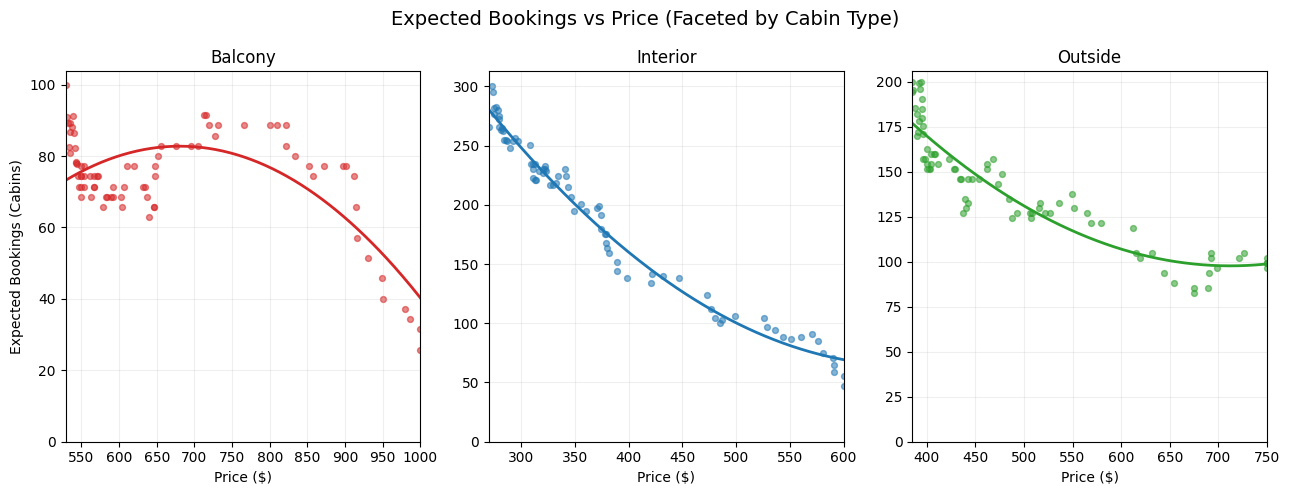

In [81]:
plot_df = (
    plot_df.sort_values("price")
      .reset_index(drop=True)
)

plot_df["avg_bookings"] = (
    plot_df.groupby("cabin_type")["bookings"]
           .rolling(window=25, min_periods=10)
           .mean()
           .reset_index(level=0, drop=True)
)

plot_df["normalized_bookings"] = (
    plot_df.groupby("cabin_type")["avg_bookings"]
           .transform(lambda x: x / x.max())
)

cabin_colors = {
    "Interior": "#1f77b4",
    "Outside": "#2ca02c",
    "Balcony": "#d62728"
}

cabins = sorted(plot_df["cabin_type"].unique())

fig, axes = plt.subplots(1, len(cabins), figsize=(13, 5), sharey=False)

for ax, cabin in zip(axes, cabins):
    subset = plot_df[
        (plot_df["cabin_type"] == cabin) &
        (plot_df["normalized_bookings"].notna())
    ].copy()

    # Convert rate → expected bookings (cabins)
    subset["expected_bookings"] = subset["normalized_bookings"] * subset["total_inventory"]

    x = subset["price"].values
    y = subset["expected_bookings"].values

    # Scatter
    ax.scatter(x, y, s=18, alpha=0.55, color=cabin_colors[cabin])

    # Smooth trend (quadratic if enough points)
    deg = 2 if len(subset) >= 3 else 1
    z = np.polyfit(x, y, deg)
    p = np.poly1d(z)

    x_vals = np.linspace(x.min(), x.max(), 200)
    ax.plot(x_vals, p(x_vals), linewidth=2, color=cabin_colors[cabin])

    price_min = int(np.floor(x.min() / 50) * 50)
    price_max = int(np.ceil(x.max() / 50) * 50)
    ax.set_xticks(np.arange(price_min, price_max + 1, 50))

    
    # Per-cabin axes
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(bottom=0)

    ax.set_title(cabin)
    ax.set_xlabel("Price ($)")
    ax.grid(alpha=0.2)

axes[0].set_ylabel("Expected Bookings (Cabins)")
fig.suptitle("Expected Bookings vs Price (Faceted by Cabin Type)", fontsize=14)
plt.tight_layout()
plt.savefig(
    "../figures/03_price_vs_expected_bookings_by_cabin.png",
    dpi=300,
    bbox_inches="tight")
plt.show()

In [82]:
keep_cols = [
    "days_to_departure",
    "date",
    "cabin_type",
    "total_inventory",
    "remaining_inventory",
    "price",
    "bookings",
    "expected_daily_bookings",
    "daily_revenue",
    "pct_sold",
    "expected_pct_sold",
    "expected_daily_pct",
    "expected_daily_revenue",
    "expected_cumulative_revenue",
    "actual_cumulative_revenue"
]

df_clean = df[keep_cols].copy()

In [83]:
ordered_cols = [
    # A) Time & identity
    "date",
    "days_to_departure",
    "cabin_type",

    # B) Inventory
    "total_inventory",
    "remaining_inventory",

    # C) Price & bookings
    "price",
    "bookings",
    "expected_daily_bookings",

    # D) Demand (actual vs expected)
    "pct_sold",
    "expected_pct_sold",

    # E) Revenue
    "daily_revenue",
    "expected_daily_revenue",
    "actual_cumulative_revenue",
    "expected_cumulative_revenue"
]
df_clean = df_clean[ordered_cols]

In [84]:
df_clean.to_csv(
    "../data/processed/cruise_pricing_with_forecast_clean.csv",
    index=False
)

print("Final dataset saved:", df_clean.shape)

Final dataset saved: (270, 14)


In [85]:
df_clean.head(10)

,date,days_to_departure,cabin_type,total_inventory,remaining_inventory,price,bookings,expected_daily_bookings,pct_sold,expected_pct_sold,daily_revenue,expected_daily_revenue,actual_cumulative_revenue,expected_cumulative_revenue
0,2025-10-21,90,Balcony,100,100,525.0,0,0,0.0,0.00,0.0,0.00,0.0,0.00
1,2025-10-21,90,Outside,200,200,351.0,8,0,0.0,0.00,2808.0,0.00,2808.0,0.00
2,2025-10-21,90,Interior,300,300,263.0,2,0,0.0,0.00,526.0,0.00,526.0,0.00
3,2025-10-22,89,Balcony,100,100,507.0,2,2,0.0,1.68,1014.0,851.76,1014.0,851.76
4,2025-10-22,89,Outside,200,192,351.0,1,2,4.0,0.97,351.0,680.94,3159.0,680.94
5,2025-10-22,89,Interior,300,298,265.0,10,1,0.7,0.19,2650.0,151.05,3176.0,151.05
6,2025-10-23,88,Balcony,100,98,509.0,1,2,2.0,3.38,509.0,865.30,1523.0,1717.06
7,2025-10-23,88,Outside,200,191,356.0,3,2,4.5,2.00,1068.0,733.36,4227.0,1414.30
8,2025-10-23,88,Interior,300,288,264.0,4,1,4.0,0.40,1056.0,166.32,4232.0,317.37
9,2025-10-24,87,Outside,200,188,358.0,4,2,6.0,3.12,1432.0,801.92,5659.0,2216.22


In [86]:
df_clean.tail(20)

,date,days_to_departure,cabin_type,total_inventory,remaining_inventory,price,bookings,expected_daily_bookings,pct_sold,expected_pct_sold,daily_revenue,expected_daily_revenue,actual_cumulative_revenue,expected_cumulative_revenue
250,2026-01-12,7,Balcony,100,18,931.0,0,0,82.0,98.75,0.0,223.44,49407.0,57295.55
251,2026-01-12,7,Outside,200,35,721.0,3,0,82.5,99.77,2163.0,72.10,76039.0,82520.62
252,2026-01-13,6,Interior,300,0,581.0,0,0,100.0,99.87,0.0,52.29,95200.0,95815.26
253,2026-01-13,6,Balcony,100,18,949.0,0,0,82.0,98.99,0.0,227.76,49407.0,57523.31
254,2026-01-13,6,Outside,200,32,726.0,3,0,84.0,99.82,2178.0,72.60,78217.0,82593.22
255,2026-01-14,5,Interior,300,0,590.0,0,0,100.0,99.90,0.0,53.10,95200.0,95868.36
256,2026-01-14,5,Outside,200,29,750.0,1,0,85.5,99.86,750.0,60.00,78967.0,82653.22
257,2026-01-14,5,Balcony,100,18,951.0,0,0,82.0,99.21,0.0,209.22,49407.0,57732.53
258,2026-01-15,4,Interior,300,0,591.0,0,0,100.0,99.93,0.0,53.19,95200.0,95921.55
259,2026-01-15,4,Outside,200,28,750.0,1,0,86.0,99.90,750.0,60.00,79717.0,82713.22
